In [1]:
from gnn_tracking.training.ml import MLModule
from pathlib import Path

import pandas as pd
import numpy as np
from numpy import ndarray as A
import torch
from gnn_tracking.utils.graph_masks import get_good_node_mask
import matplotlib.pyplot as plt
import tqdm

from ocpaper231.data import get_dm
import scienceplots
plt.style.use(["science", "notebook"])
from gnn_tracking.training.tc import TCModule

from torch_geometric.data import Data
import torch

from gnn_tracking.utils.log import logger
logger.setLevel("WARNING")


In [2]:
data = torch.load("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt")

In [7]:
chkpt_home = Path("/scratch/gpfs/kl5675/checkpoints/animation/")
assert chkpt_home.is_dir()

In [8]:
latent_spaces = []

class LatentSpaceCollector:
    def __init__(self, data: Data, out_dir: Path):
        out_dir.mkdir(parents=True, exist_ok=True)
        self._data = data
        self.out_dir = out_dir
    
    @staticmethod
    def get_step(path: Path) -> int:
        return int(path.stem.split("=")[-1])
    
    def get_all_latent_spaces(self, chkpt_home: Path, max_i=None):
        chkpt_files = list(chkpt_home.glob("*.ckpt"))
        print(f"Found {len(chkpt_files)} checkpoints")
        chkpts = sorted(chkpt_files, key=self.get_step)[:max_i]
        for chkpt in tqdm.tqdm(chkpts):
            step = self.get_step(chkpt)
            latent_space = self.get_latent_space(step, chkpt)
            latent_spaces.append(latent_space)
        return latent_spaces
    
    def get_latent_space(self, step: int, chkpt) -> A:
        latent_space = self._load_latent_space(step)
        if latent_space is None:
            latent_space = self._get_fresh_latent_space(chkpt)
            self._save_latent_space(latent_space, step)
        return latent_space

    def _load_latent_space(self, step: int) -> A|None:
        path = self.out_dir / f"{step}.npy" 
        if path.is_file():
            return np.load(path)

    def _save_latent_space(self, latent_space: A, step: int):
        np.save(self.out_dir / f"{step}.npy", latent_space)

    def _get_fresh_latent_space(self, chkpt):
        model = TCModule.load_from_checkpoint(chkpt)
        return model(self._data)["H"].detach().cpu().numpy()



In [12]:
lsc = LatentSpaceCollector(data, chkpt_home / "latent_spaces")
spaces = lsc.get_all_latent_spaces(chkpt_home, max_i=50)

Found 95 checkpoints


100%|███████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 644.50it/s]


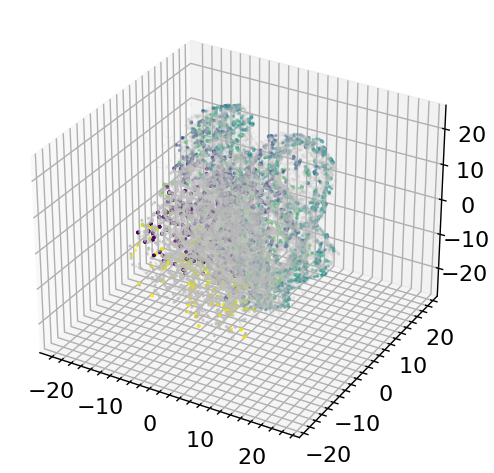

In [31]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mask = get_good_node_mask(data)
h = spaces[-1][mask]
hn = spaces[-1][~mask]
ax.scatter(hn[:, 0], hn[:, 1], hn[:, 2], alpha=0.3, c="silver", s=0.3)
ax.scatter(h[:, 0], h[:, 1], h[:, 2], alpha=0.4, c=data.eta[mask], cmap="viridis", s=2)

In [36]:
import matplotlib.animation  as animation
from gnn_tracking.analysis.latent import get_color_mapper 


class Animator:
    def __init__(self, data: Data, latent_spaces: list[A], dims=(0, 1), selected_pids=None):
        self._data = data
        self._latent_spaces = latent_spaces
        self._dims = dims
        if selected_pids is None:
            selected_pids = np.random.choice(data.particle_id[get_good_node_mask(data)].unique(), 6)
        self._color_mapper = get_color_mapper(selected_pids)
        self._selected_pid_mask = np.isin(data.particle_id, selected_pids)
        self._normalized_hs = []


    def normalize_h(self, h: A) -> A:
        h -= h.mean(axis=0)
        new_norm = h.sum(axis=1).std(axis=0)
        self._normalized_hs.append(h / new_norm)
        return np.array(self._normalized_hs)[-3:].mean(axis=0)

    def animate(self):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        mask = get_good_node_mask(data)
        h = self.normalize_h(self._latent_spaces[0])

        # sc_noise = ax.scatter(h[~mask, self._dims[0]], h[~mask, self._dims[1]], alpha=0.2, s=1, c="silver")
        sc = ax.scatter(h[mask, 0], h[mask, 1], h[mask, 2], alpha=0.2,
            s=1,
            # c="black", 
            c=self._data.eta[mask], cmap="viridis"
            )
        # sc3 = ax.scatter(
        #     h[self._selected_pid_mask, self._dims[0]],
        #     h[self._selected_pid_mask, self._dims[1]],
        #     # c=,
        #     marker="o",
        #     facecolors="none",
        #     edgecolors=self._color_mapper(self._data.particle_id[self._selected_pid_mask]),
        #     linewidths=2.0,
        # )

        def update(frame):
            # Update scatter plot data for the current frame
            h = self.normalize_h(self._latent_spaces[frame])
            # sc_noise.set_offsets(np.c_[h[~mask, self._dims[0]], h[~mask, self._dims[1]]])
            # print(h.mean())
            # sc.set_offsets(np.c_[h[mask, 0], h[mask, 1], h[mask, 2]])
            sc._offsets3d = (h[mask, 0], h[mask, 1], h[mask, 2])
            # sc3.set_offsets(np.c_[h[self._selected_pid_mask, self._dims[0]], h[self._selected_pid_mask, self._dims[1]]])

        # Create animation, assuming len(self._latent_spaces) frames
        return animation.FuncAnimation(fig, update, frames=len(self._latent_spaces), blit=False)

a = Animator(data, spaces, dims=(1, 2))
anim = a.animate() 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/home/kl5675/Documents/23/git_sync/klieret-gnn-tracking-experiments/notebooks/0051_0100/latent_spaces_animation.mp4', writer=writer)
plt.show()